In [ ]:
%pip install pillow pillow-heif matplotlib opencv-python numpy

In [2]:
from PIL import Image, ImageOps, ImageChops
from pillow_heif import register_heif_opener
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
register_heif_opener()
DATASET_ROOT = "./Dataset/"

# Convert HEIC images to JPG

In [6]:
for img_path in os.listdir(DATASET_ROOT + "AmirHossein"):
    if img_path.endswith(".HEIC"):
        img = Image.open(DATASET_ROOT + "AmirHossein/" + img_path)
        img.save(DATASET_ROOT + "AmirHossein/" + "JPG/" + img_path[:-5] + ".jpg", format="jpeg")

## Split the main images from blurred ones

In [12]:
for img_path in os.listdir(DATASET_ROOT + "AmirHossein/" + "JPG/"):
    name = img_path.split(".")[0]
    image = Image.open(DATASET_ROOT + "AmirHossein/" + "JPG/" + img_path)

    if name.endswith("(1)"):
        name = name[:-3]
        image.save(DATASET_ROOT + "AmirHossein/" + "Blurred/" + name + ".jpg")
    else:
        image.save(DATASET_ROOT + "AmirHossein/" + "Original/" + name + ".jpg")

In [18]:
for i, img_path in enumerate(sorted(os.listdir(DATASET_ROOT + "Mehrab/"))):
    name = img_path.split(".")[0]
    if name == "Original" or name == "Blurred":
        continue
    image = Image.open(DATASET_ROOT + "Mehrab/" + img_path)

    if i % 2 == 1:  # It's the original image
        image.save(DATASET_ROOT + "Mehrab/" + "Original/" + name + ".jpg")
    else:  # It's the blurred image
        image.save(DATASET_ROOT + "Mehrab/" + "Blurred/" + name + ".jpg")

In [19]:
lst = os.listdir(DATASET_ROOT + "Mohammad/")
lst = sorted(lst)
print(lst)
#TODO

['20230802_102806.jpg', '20230802_102816.jpg', '20230802_102840.jpg', '20230802_103013.jpg', '20230802_103052.jpg', '20230802_103413.jpg', '20230802_103511.jpg', '20230802_103517.jpg', '20230802_110902.jpg', '20230802_110913.jpg', '20230802_110928.jpg', '20230802_111154.jpg', '20230802_111225.jpg', '20230802_112031.jpg', '20230802_112039.jpg', '20230802_121323.jpg', '20230802_121346.jpg', '20230802_121447.jpg', '20230802_121458.jpg', '20230802_121517.jpg', '20230802_121847.jpg', '20230802_121936.jpg', '20230802_121950.jpg', '20230802_121956.jpg', '20230802_122420.jpg', '20230802_122432.jpg', '20230802_122643.jpg', '20230802_122648.jpg', '20230802_122655.jpg', '20230802_122755.jpg', '20230802_122803.jpg', '20230802_132512.jpg', '20230802_132530.jpg', '20230802_132738.jpg', '20230802_132747.jpg', '20230802_134623.jpg', '20230802_134636.jpg', '20230802_134640.jpg', '20230802_134642.jpg', '20230802_135151.jpg', '20230802_135204.jpg', '20230802_135444.jpg', '20230802_135455.jpg', '20230802_

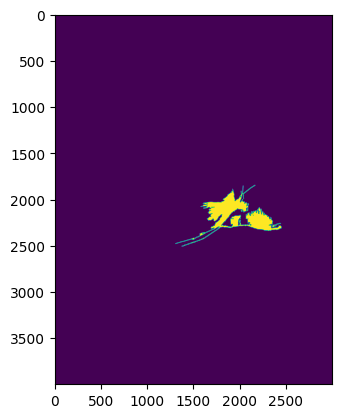

In [57]:
from PIL import ImageFilter


def extract_background(blurred_path):
    # load image
    img = cv2.imread(blurred_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # canny
    canned = cv2.Canny(gray, 100, 200)

    # dilate to close holes in lines
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(canned, kernel, iterations=1)

    # find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # find big contours
    biggest_cntr = None
    biggest_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > biggest_area:
            biggest_area = area
            biggest_cntr = contour

    # draw contours
    crop_mask = np.zeros_like(mask)
    cv2.drawContours(crop_mask, [biggest_cntr], -1, (255), -1)

    # fill in holes
    # inverted
    inverted = cv2.bitwise_not(crop_mask)

    # contours again
    contours, _ = cv2.findContours(inverted, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # find small contours
    small_cntrs = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 20000:
            print(area)
            small_cntrs.append(contour)

    # draw on mask
    cv2.drawContours(crop_mask, small_cntrs, -1, (255), -1)

    # opening + median blur to smooth jaggies
    crop_mask = cv2.erode(crop_mask, kernel, iterations=1)
    crop_mask = cv2.dilate(crop_mask, kernel, iterations=1)
    crop_mask = cv2.medianBlur(crop_mask, 5)

    # crop image
    crop = np.zeros_like(img)
    crop[crop_mask == 255] = img[crop_mask == 255]

    plt.imshow(crop_mask)

extract_background(
    "./Dataset/Iman Mohammadi/Blured/01.jpg"
)

In [4]:
from tqdm import tqdm

dirs = set(os.listdir(DATASET_ROOT)) - {
    "GT_Images",
    "Masks",
    "Input_Images",
    ".DS_Store",
    # "Mohammad",  # TODO
    # "Soroush",
    # "AmirHossein",
    # "Iman Mohammadi",
    # "Mehrab",
}

i = 0
if len(os.listdir(DATASET_ROOT + "Input_Images/")) > 0:
    lst = sorted(os.listdir(DATASET_ROOT + "Input_Images/"))
    last_item = lst[-1].split(".")[0]
    i = int(last_item) + 1
    print("Starting from image number: ", i)

for folder_name in tqdm(dirs):
    orig_path = os.path.join(DATASET_ROOT, folder_name, "Original/")
    blur_path = os.path.join(DATASET_ROOT, folder_name, "Blurred/")

    for img_path in os.listdir(orig_path):
        name = img_path.split(".")[0]
        if img_path == ".DS_Store":
            continue

        original = Image.open(orig_path + img_path)
        blurred = Image.open(blur_path + name + ".jpg")

        original.save(
            os.path.join(DATASET_ROOT, "Input_Images", str(i) + ".jpg"), format="jpeg"
        )
        blurred.save(
            os.path.join(DATASET_ROOT, "GT_Images", str(i) + ".jpg"), format="jpeg"
        )
        i += 1

100%|██████████| 4/4 [02:47<00:00, 41.90s/it]


In [6]:
if len(os.listdir(DATASET_ROOT + "Input_Images/")) > 0:
    lst = sorted(
        os.listdir(DATASET_ROOT + "Input_Images/"), key=lambda x: int(x.split(".")[0])
    )
    last_item = lst[-1].split(".")[0]
    i = int(last_item) + 1
    print("Starting from image number: ", i)

Starting from image number:  508


In [8]:
folder_name = "Mohammad"

orig_path = os.path.join(DATASET_ROOT, folder_name, "Original/")
blur_path = os.path.join(DATASET_ROOT, folder_name, "Blurred/")

for img_path in os.listdir(orig_path):
    name = img_path.split(".")[0]
    if img_path == ".DS_Store":
        continue

    original = Image.open(orig_path + img_path)
    blurred = Image.open(blur_path + name + ".jpg")

    original.save(
        os.path.join(DATASET_ROOT, "Input_Images", str(i) + ".jpg"), format="jpeg"
    )
    blurred.save(
        os.path.join(DATASET_ROOT, "GT_Images", str(i) + ".jpg"), format="jpeg"
    )
    i += 1

In [9]:
img_amir = Image.open(DATASET_ROOT + 'AmirHossein/Original/' + 'IMG_3278.JPG')
img_moh = Image.open(DATASET_ROOT + 'Mohammad/Original/' + '20230802_194210.JPG')
img_meh = Image.open(DATASET_ROOT + 'Mehrab/Original/' + '0.JPG')
img_sor = Image.open(DATASET_ROOT + 'Soroush/Original/' + '20230801_192300.jpg')
img_im = Image.open(DATASET_ROOT + 'Iman Mohammadi/Original/' + '01.jpg')

print(img_amir.size)
print(img_moh.size)
print(img_meh.size)
print(img_sor.size)
print(img_im.size)

(3024, 4032)
(4000, 1800)
(4032, 3024)
(4000, 3000)
(4000, 3000)


In [10]:
# Copy Images from ./Dataset/Input_Images and ./Dataset/GT_Images to ./Dataset_Final/Input_Images and ./Dataset_Final/GT_Images
# And also change the width and height of all of them to 512x512

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input Images
input_images_path = "./Dataset/Input_Images/"
input_images = os.listdir(input_images_path)
input_images = sorted(input_images, key=lambda x: int(x.split(".")[0]))

# GT Images
gt_images_path = "./Dataset/GT_Images/"
gt_images = os.listdir(gt_images_path)
gt_images = sorted(gt_images, key=lambda x: int(x.split(".")[0]))

# Create the new folders
os.mkdir("./Dataset_Final/Input_Images/")
os.mkdir("./Dataset_Final/GT_Images/")

# Copy the images
for i in range(len(input_images)):
    # Input Images
    img = cv2.imread(input_images_path + input_images[i])
    img = cv2.resize(img, (512, 512))
    cv2.imwrite("./Dataset_Final/Input_Images/" + input_images[i], img)

    # GT Images
    img = cv2.imread(gt_images_path + gt_images[i])
    img = cv2.resize(img, (512, 512))
    cv2.imwrite("./Dataset_Final/GT_Images/" + gt_images[i], img)

print("Done!")

Done!


In [5]:
import tensorflow_datasets as tfds

ds = tfds.load("tensorflow_portset", split="all_data")

In [ ]:
import matplotlib.pyplot as plt
import os

for data in ds:
    # Create a row of 2 images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Show the input image
    ax[0].imshow(data["input_image"])
    ax[0].set_title("Input image")
    # Show the target image
    ax[1].imshow(data["blurred_image"])
    ax[1].set_title("Blurred image")
    print(data["input_image"].shape)
    print(data["blurred_image"].shape)
    plt.show()

In [4]:
from PIL import Image
Image.open("./Dataset/Input_Images/1.jpg").size

(512, 512)

In [28]:
from torch_portset.portset_dataset import PortsetDataset

sample_ds = PortsetDataset(root="./Dataset", transform=None, target_transform=None)
sample_ds[0]

ImportError: cannot import name 'PortsetDataset' from 'torch_portset' (/Users/amirhossein/Documents/University/Digital Image Processing/PortSet/torch_portset/__init__.py)